### Python Study Group week 1

### Theme:

------------------------------------------------------------

### Let's get it started !

### Import Libraries

In [2]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook
from IPython.display import clear_output

import numpy as np
import pandas as pd
import os

### 撰寫對網站發出請求(requests)的function

Note: 因後續會不斷使用到，故我們可把它寫成一個簡短的function以便後續重複使用。

In [3]:
def get_web_page(url):
    resp = requests.get(url)
    resp.encoding = 'utf-8'
    
    if resp.status_code != 200:
        print('Invalid url:', resp.url)
        return None
    else:
        return resp.text

----------------------------------------------------------

### Parse HTML

```
Target:
我們想取得熱門電影資訊，並把它整理成 DataFrame 形式。
```

```
Note:
(1) 在此範例使用 BeautifulSoup 去解析 HTML。
(2) 除了 if/else 外，在寫爬蟲時經常會使用 try/except 方式撰寫，以避免產生錯誤時突然中斷程式。
```

In [4]:
def get_popular_movie_intro(dom):
    soup = BeautifulSoup(dom, 'html.parser')
    
    # get information by rows
    movie_rows = soup.find_all('div', class_='tr')
    
    movie_urls = []
    movie_info = []
    
    for index, row in enumerate(movie_rows):
        if index == 0:
            cols = row.text.split('\n')
            cols = [col for col in cols if col]  # remove empty element in list
            cols.remove('預告片')
            print(cols)
            
        elif index == 1:
            first_col = row.text.split()

        else:
            try:
                thisweek_rank = row.find_next('div', class_='td')
                temp = thisweek_rank.find_next('div', class_='td') # it will be empty
                lastweek_rank = temp.find_next('div', class_='td')

                
                movie_name = lastweek_rank.find_next('div', class_='td')
                release_date = movie_name.find_next('div', class_='td')
                movie_urls.append(lastweek_rank.find_next('div', class_='td').find('a')['href'])
                count = row.find('div', class_='td starwithnum').find('h6', class_='count')
                
                movie_info.append([thisweek_rank.text, lastweek_rank.text, movie_name.text.strip(), release_date.text, float(count.text)])
                
                # transform movie_info from list to 2d-array
                movie_info_arr = np.array(movie_info)
                
                # transform movie_info_arr to dataframe
                movie_df = pd.DataFrame(movie_info_arr, columns=cols)
                
            except:
                continue
    
    return movie_df, movie_urls

```
撰寫完成
- 發出請求 
- 爬取電影資料 
兩個 function，我們就可把參數餵進去取得想要的資料。
```

In [5]:
# Target url: Yahoo Movie (url)
popmovie_url = 'https://movies.yahoo.com.tw/chart.html'

popular_movie = get_web_page(popmovie_url)
movie_df, movie_urls = get_popular_movie_intro(popular_movie)
movie_df.head() 

['本週', '上週', '片名', '上映日期', '網友滿意度']


,本週,上週,片名,上映日期,網友滿意度
0,2,1,黑魔女2,2019-10-17,4.1
1,3,2,小丑,2019-10-03,4.5
2,4,,陪你很久很久,2019-10-25,4.3
3,5,3,返校,2019-09-20,4.3
4,6,,金翅雀,2019-10-25,3.9


----------------------------------------------------------

### 一些簡單小探索

由以上之熱門電影，我們可能想知道為何此幾部電影會如此熱門，可能是導演、演員、劇情細節···等。

>搜集演員人氣資訊

取得演員名稱與演員人氣資訊 -> 使用 dictionary 形成映射。

In [6]:
def get_pop_num(movie_urls):
    actor_pop = {}
    
    for index, url in enumerate(movie_urls):
        # 取得前五名電影之 url 以探索
        if index <= 5:
            movie_page = get_web_page(url)
            movie_soup = BeautifulSoup(movie_page, 'html.parser')
            movie_name = movie_soup.find('div', class_='movie_intro_info_r').find('h1').text
            actor_list = movie_soup.find_all('div', class_='movie_intro_list')[1].find_all('a')

            actor_href = [actor['href'] for actor in actor_list]

            for href in actor_href:
                actor_page = get_web_page(href)
                actor_soup = BeautifulSoup(actor_page, 'html.parser')

                name = actor_soup.find('h1', class_='maker_name').text
                name = name + '(' + movie_name + ')'
                popular = int(actor_soup.find('div', class_='popnum').text.split('：')[1])
                actor_pop[name] = popular
    
    return actor_pop

In [7]:
actor_pop = get_pop_num(movie_urls)
actor_pop

{'安潔莉娜裘莉Angelina Jolie(黑魔女2)': 11918,
 '艾兒芬妮Elle Fanning(黑魔女2)': 11689,
 '蜜雪兒菲佛Michelle Pfeiffer(黑魔女2)': 16871,
 '朱諾坦普Juno Temple(黑魔女2)': 6115,
 '山姆萊利Sam Riley(黑魔女2)': 1138,
 '蕾絲莉蔓薇爾Lesley Manville(黑魔女2)': 4474,
 '瓦昆菲尼克斯Joaquin Phoenix(小丑)': 16363,
 '勞勃狄尼洛Robert De Niro(小丑)': 12913,
 '希亞溫漢Shea Whigham(小丑)': 5122,
 '邵雨薇(陪你很久很久)': 2498,
 '王淨(返校)': 5957,
 '曾敬驊(返校)': 2731,
 '傅孟柏(返校)': 3922,
 '妮可基嫚Nicole Kidman(金翅雀)': 18944,
 '莎拉保羅森Sarah Paulson(金翅雀)': 11995,
 '安索艾格特Ansel Elgort(金翅雀)': 11098,
 '艾紐林巴納德Aneurin Barnard(金翅雀)': 3065,
 '賴雅妍(聖人大盜)': 1780,
 '曾之喬(聖人大盜)': 950,
 '曾志偉Eric Tsang(聖人大盜)': 9682,
 '巫建和(聖人大盜)': 3361,
 '路斯明(聖人大盜)': 1848}

----------------------------------------------------------

根據 dictionary value (popular number) 排序並畫圖

In [13]:
sorted_actor_pop = sorted(actor_pop.items(), key=lambda x: x[1])
pop_arr = np.array([list(pairs) for pairs in sorted_actor_pop])  
actor_pop_df = pd.DataFrame(pop_arr, columns=['actor', 'popularity'])

# 確保演員的 popularity 為整數(int)
actor_pop_df['popularity'] = actor_pop_df['popularity'].astype(int)
actor_pop_df.head()

,actor,popularity
0,曾之喬(聖人大盜),950
1,山姆萊利Sam Riley(黑魔女2),1138
2,賴雅妍(聖人大盜),1780
3,路斯明(聖人大盜),1848
4,邵雨薇(陪你很久很久),2498


<Figure size 2160x1440 with 0 Axes>

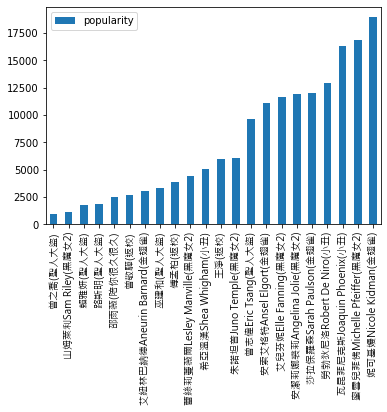

In [21]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
plt.figure(figsize=(30, 20))

myfont = FontProperties(fname='/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/Microsoft JhengHei.ttf')
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
clear_output()

ax = actor_pop_df.plot(kind='bar')
ax.set_xticklabels(actor_pop_df['actor'], fontproperties=myfont)
plt.show()

----------------------------------------------------------

## 討論影評留言與網友滿意度之間的關係

> 此以電影 "返校" 為例。

In [33]:
def create_movie_url(movie_id):
    movie_review_url = 'https://movies.yahoo.com.tw/movieinfo_review.html/id='
    sort_order = '?sort=rating1&order=desc&page='
    
    return "{0}{1}{2}".format(movie_review_url, movie_id, sort_order)

In [34]:
def get_review(dom):
    soup = BeautifulSoup(dom, 'html.parser')
    
    # reviews 被包裝在 ul (unorder list 中)，每一則 review 被一個 <li></li> 所夾
    uls = soup.find('ul', class_='usercom_list')
    lists = uls.find_all('li')
    
    reviews = []
    # 對於每則 review，我們要取出他的內容
    for li in lists:
        div = li.find('div', class_='usercom_inner _c')
        review = div.find_all('span')[2].text.strip()  # 使用 find_all 將會回傳 list，包含所有符合條件的物件。
        
        reviews.append(review)
    
    return reviews

In [35]:
movie_id = '10109' # 10109 -> "返校"
movie_url = create_movie_url(movie_id)

# If stars more and equal to 3 -> good reviews; otherwise, bad reviews.
last_page = 167
good_review_page = 145
    
good_reviews = []
bad_reviews = []

for i in tqdm_notebook(range(last_page+1)):
    try:
        review_url = "{0}{1}".format(movie_url, i)
        current_page = get_web_page(review_url)
            
        if i <= good_review_page:
            good_reviews.extend(get_review(current_page))
        else:
            bad_reviews.extend(get_review(current_page))
            
    except:
        continue
 
 # 將字詞中的空白、分隔線去除
good_reviews = [x.replace('\r', '').replace('\n', '') for x in good_reviews]
bad_reviews = [x.replace('\r', '').replace('\n', '') for x in bad_reviews]
    
 # 幫好的評論加上標記(標準：三顆星以上設為 good，其餘反之)
good_sentiment = np.array([1]*len(good_reviews)).reshape(1, -1).ravel()
bad_sentiment = np.array([0]*len(bad_reviews)).reshape(1, -1).ravel()


good_df = pd.DataFrame([good_reviews, good_sentiment]).T
bad_df = pd.DataFrame([bad_reviews, bad_sentiment]).T
    
reviews_df = pd.concat([good_df, bad_df])
reviews_df.columns=['reviews', 'sentiment']
reviews_df.index = pd.RangeIndex(len(reviews_df.index))
reviews_df.head()

,reviews,sentiment
0,非常震撼！國片能拍出這樣的質感也不辜負原作，我覺得與有榮焉。 最後：致自由！,1
1,如果只想看單純恐怖片或者恐怖點很高的話就不建議看返校會給這部電影滿分是真的有把戒嚴時期的壓抑...,1
2,發人深省的一部電影 這部國片真的要支持一下 然後教官長得像韓國魚...,1
3,這部一定是五毛跟9.2最大的夢靨,1
4,大推！高品質國片！看完後得到許多反思～結局很感人！,1
